In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, Conv1D, MaxPooling1D, MaxPooling2D, AveragePooling2D, Conv2D, Flatten, Dropout, Input, concatenate, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
from matplotlib.colors import LogNorm 

Functions used throughout the notebook:
- Pend_Law : given lengths. outputs the periods;
- Lengths : generate an array of lengths given start, end and steps. Resized to be a 1D column vector;
- Grav_Acc : given periods and lengths, outputs acceleration of gravity;
- Pred_Rescale : reshape of the prediction array obtained as output from the model;
- Diff : evaluate difference between prediction of the model and generated periods;

In [2]:
def Pend_Law(L):
    T = []
    g = 9.81 #m/s^2
    size = 0
    for l in L:
        period = 2*np.pi*np.sqrt(l/g)
        T = np.append(T, period)
        size = size + 1
    T = T.reshape(size, 1)
    return T

#call this function for fit only
def PendLawFit(L, acc):
    T = []
    for l in L:
        period = 2*np.pi*np.sqrt(l/acc)
        T = np.append(T, period)
    return T


def Lengths(first, last, step):
    L = np.array([[]])
    L = np.append(L, first)
    length = first + step
    size = 1
    while length < last:
        L = np.append(L, length)
        length = length + step
        size = size + 1
    L = L.reshape(size, 1)
    return L

def Grav_Acc(p, l):
    i = 0
    g = np.zeros(len(p))
    while i < len(p):
        g[i] = 4*np.pi*np.pi*l[i]/(p[i]**2)
        i = i + 1
    return g

def Pred_Rescale(prediction):
    size = 0
    for p in prediction:
        size = size + 1
    final = prediction.reshape(size, 1)
    return final

def Diff(prediction, generated):
    if len(prediction) < len(generated):
        diff = np.transpose(np.zeros(len(prediction)))
        diff = diff.reshape(len(diff), 1)
        
        i = 0
        
        while i < len(diff):
            diff[i, 0] = prediction[i, 0] - generated[i, 0]
            i = i + 1
    else:
        diff = np.transpose(np.zeros(len(generated)))
        diff = diff.reshape(len(diff), 1)
        
        i = 0
        
        while i < len(diff):
            diff[i, 0] = prediction[i, 0] - generated[i, 0]
            i = i + 1
        
    return diff

Generate vector of lengths of an interval picked at random. Subsequently, generate the corresponding periods according
to the pendulum law.

In [3]:
lengths = Lengths(1.2, 7.8, 0.0001)

periods = Pend_Law(lengths)

Split both arrays for the training, test and validation of the model.

In [4]:
length_train, length_val = train_test_split(lengths, train_size = 0.70, random_state = 0)

period_train, period_val = train_test_split(periods, train_size = 0.70, random_state = 0)

In [5]:
length_test = Lengths(1.2, 8.7, 0.0002)

period_test = Pend_Law(length_test)

Create the model.

In [ ]:
input_layer = Input(shape = (1, 1))

In [7]:
Conv_1 = Conv1D(8, kernel_size = 1)(input_layer)
Activation_1 = Activation("relu")(Conv_1)
Conv_2 = Conv1D(16, kernel_size = 1)(Activation_1)
Activation_2 = Activation("relu")(Conv_2)
Conv_3 = Conv1D(32, kernel_size = 1)(Activation_2)
Activation_3 = Activation("relu")(Conv_3)
Conv_4 = Conv1D(64, kernel_size = 1)(Activation_3)
Activation_4 = Activation("relu")(Conv_4)
Conv_5 = Conv1D(128, kernel_size = 1)(Activation_4)
Activation_5 = Activation("relu")(Conv_5)

In [8]:
Dense_1 = Dense(128, activation = "relu")(Activation_5)
Dense_2 = Dense(64, activation = "relu")(Dense_1)
Dense_3 = Dense(32, activation = "relu")(Dense_2)
Dense_4 = Dense(16, activation = "relu")(Dense_3)
Dense_5 = Dense(8, activation = "relu")(Dense_4)
Dense_6 = Dense(4, activation = "relu")(Dense_5)
Dense_Out = Dense(1, activation = "relu")(Dense_6)

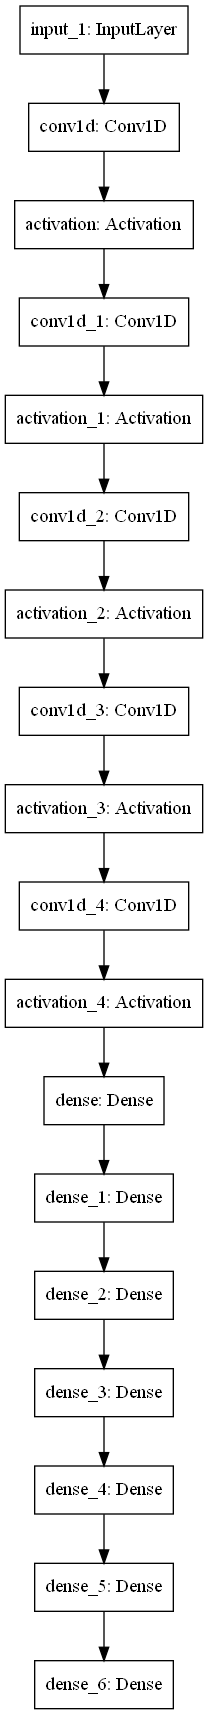

In [9]:
Pend_Law_Model = Model(inputs = input_layer, outputs = Dense_Out)

keras.utils.plot_model(Pend_Law_Model)

In [10]:
Pend_Law_Model.compile(loss = "mse", optimizer = "adam")
Pend_Law_Model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 1)]            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 8)              16        
_________________________________________________________________
activation (Activation)      (None, 1, 8)              0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             144       
_________________________________________________________________
activation_1 (Activation)    (None, 1, 16)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1, 32)             544       
_________________________________________________________________
activation_2 (Activation)    (None, 1, 32)             0     

In [61]:
#if this gives problems (the val_loss stays at approx. 18 for all the epochs), restarting all the cells in the notebook
                        #will fix the issue. May be required more times)

Start the learning of the model.

In [11]:
Pend_Law_Best = ModelCheckpoint('Pend_Law_Best_Model.hdf5', save_best_only = True, monitor = "val_loss", mode = "min")
epochs = 30
history = Pend_Law_Model.fit(x = length_train, y = period_train, validation_data = (length_val, period_val), epochs = epochs, batch_size = 6, shuffle = True, callbacks = (Pend_Law_Best))

Epoch 1/30
7700/7700 [==============================] - 8s 953us/step - loss: 0.3331 - val_loss: 0.0031
Epoch 2/30
7700/7700 [==============================] - 7s 864us/step - loss: 7.7669e-04 - val_loss: 3.3459e-04
Epoch 3/30
7700/7700 [==============================] - 7s 882us/step - loss: 5.9242e-04 - val_loss: 3.1334e-04
Epoch 4/30
7700/7700 [==============================] - 7s 891us/step - loss: 2.8895e-04 - val_loss: 2.2468e-04
Epoch 5/30
7700/7700 [==============================] - 7s 900us/step - loss: 2.8234e-04 - val_loss: 0.0012
Epoch 6/30
7700/7700 [==============================] - 7s 904us/step - loss: 2.4413e-04 - val_loss: 1.7270e-05
Epoch 7/30
7700/7700 [==============================] - 7s 921us/step - loss: 2.0282e-04 - val_loss: 1.1203e-05
Epoch 8/30
7700/7700 [==============================] - 7s 907us/step - loss: 1.6015e-04 - val_loss: 1.0655e-05
Epoch 9/30
7700/7700 [==============================] - 7s 911us/step - loss: 2.5656e-04 - val_loss: 8.4807e-06
Epoc

Quick look at the loss functions for the train and the evaluation.

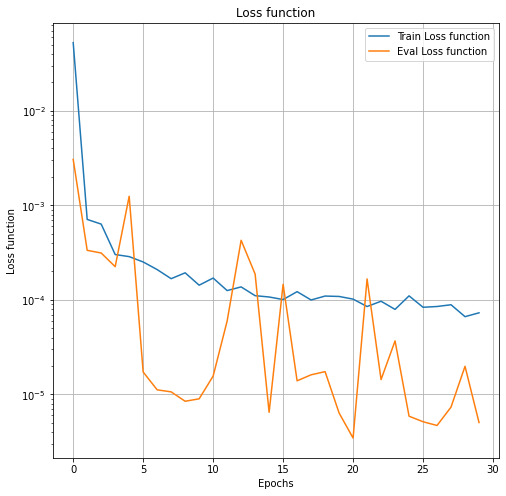

In [13]:
train_loss_fn = history.history["loss"]
eval_loss_fn = history.history["val_loss"]
epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, train_loss_fn, label = "Train Loss function")
plt.plot(epochs_range, eval_loss_fn, label = "Eval Loss function")
plt.legend(loc = "upper right")
plt.title("Loss function")
plt.xlabel("Epochs")
plt.grid()

plt.yscale('log')
plt.ylabel("Loss function")
plt.show()

Ask the model to make predictions on the test lengths

In [14]:
pred = Pend_Law_Model.predict(length_test)

Evaluate the acceleration of gravity via the pendulum law for two arrays:
- pred_rescaled : array of periods predicted by the model, then rescaled;
- periods : periods generated

In [15]:
pred_rescaled = Pred_Rescale(pred)

grav_acc = Grav_Acc(pred_rescaled, length_test)
grav_gen = Grav_Acc(periods, lengths)

Compare the periods obtained via the model with the ones generated

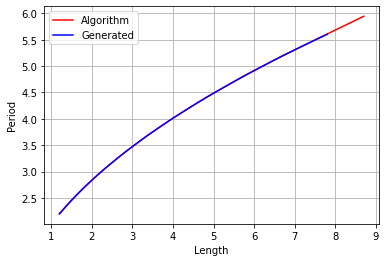

In [37]:
plt.plot(length_test, pred_rescaled, color = 'r', label = 'Algorithm')
plt.plot(lengths, periods, color = 'b', label = "Generated")
plt.xlabel('Length')
plt.ylabel('Period')
plt.grid()
plt.legend(loc = 'best')

Zoom in on a particular region

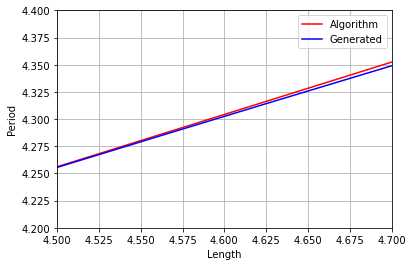

In [40]:
plt.plot(length_test, pred_rescaled, color = 'r', label = 'Algorithm')
plt.plot(lengths, periods, color = 'b', label = "Generated")
plt.axis([4.5, 4.7, 4.2, 4.4])
plt.xlabel('Length')
plt.ylabel('Period')
plt.grid()
plt.legend(loc = 'best')

In [48]:
np.shape(grav_acc)

(37500,)

In [56]:
np.linspace(1, 37500)

array([1.00000000e+00, 7.66285714e+02, 1.53157143e+03, 2.29685714e+03,
       3.06214286e+03, 3.82742857e+03, 4.59271429e+03, 5.35800000e+03,
       6.12328571e+03, 6.88857143e+03, 7.65385714e+03, 8.41914286e+03,
       9.18442857e+03, 9.94971429e+03, 1.07150000e+04, 1.14802857e+04,
       1.22455714e+04, 1.30108571e+04, 1.37761429e+04, 1.45414286e+04,
       1.53067143e+04, 1.60720000e+04, 1.68372857e+04, 1.76025714e+04,
       1.83678571e+04, 1.91331429e+04, 1.98984286e+04, 2.06637143e+04,
       2.14290000e+04, 2.21942857e+04, 2.29595714e+04, 2.37248571e+04,
       2.44901429e+04, 2.52554286e+04, 2.60207143e+04, 2.67860000e+04,
       2.75512857e+04, 2.83165714e+04, 2.90818571e+04, 2.98471429e+04,
       3.06124286e+04, 3.13777143e+04, 3.21430000e+04, 3.29082857e+04,
       3.36735714e+04, 3.44388571e+04, 3.52041429e+04, 3.59694286e+04,
       3.67347143e+04, 3.75000000e+04])

1D histogram of the differences between the predicted values of the acceleration of gravity against the value of 9.81 m/$s^2$

(array([  464.,   490.,   515.,   552.,   596.,   661.,   995.,  7191.,
        15992., 10044.]),
 array([-0.08937558, -0.07995485, -0.07053411, -0.06111338, -0.05169264,
        -0.04227191, -0.03285117, -0.02343044, -0.0140097 , -0.00458897,
         0.00483177]),
 <BarContainer object of 10 artists>)

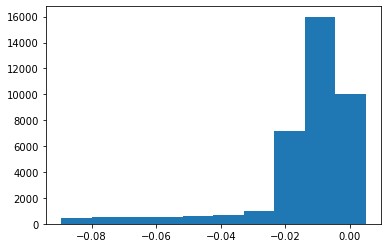

In [59]:
plt.hist(grav_acc - grav_gen[:37500], label = 'Pred - Gen')

In [20]:
pred_2d = pred_rescaled.reshape(37500)
period_test_2d = period_test.reshape(37500)

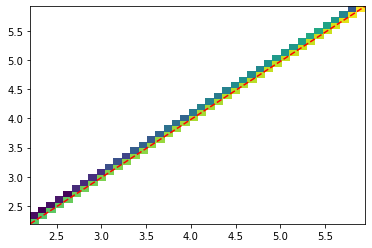

In [21]:
plt.hist2d(pred_2d, period_test_2d, bins = 40, norm = LogNorm())
plt.plot([pred_2d[0], pred_2d[-1]], [period_test_2d[0], period_test_2d[-1]], 'r--')

In [22]:
print('Period RMSE = ',np.sqrt(mean_squared_error(pred_rescaled[:], period_test[:])))
print('Period MAE = ', (mean_absolute_error(pred_rescaled[:], period_test[:])))

print('Grav Accel RMSE = ',np.sqrt(mean_squared_error(grav_acc[:], grav_gen[:len(grav_acc)])))
print('Grav Accel MAE = ', (mean_absolute_error(grav_acc[:], grav_gen[:len(grav_acc)])))

Period RMSE =  0.005961108795949892
Period MAE =  0.0033898267914685507
Grav Accel RMSE =  0.02118410975132675
Grav Accel MAE =  0.013702482737096155
